In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
sns.set(color_codes=True)

In [7]:
from scipy.sparse import lil_matrix
data = np.random.rand(500, 500)
sparse_user_mer_matrix = lil_matrix(data)
print(sparse_user_mer_matrix.shape)
clustering = SpectralClustering(n_clusters=10,
                                n_init=10, 
                                gamma=1.0,
                                affinity='precomputed',
                                assign_labels ='kmeans',
                                n_jobs=5)
cls = clustering.fit(sparse_user_mer_matrix)
print(cls.labels_[:10])

(500, 500)


/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


[0 8 8 5 0 8 1 6 0 6]


In [8]:
df1 = pd.DataFrame(pd.read_csv('./data/ijcai2016_koubei_train.csv',header=0))

In [2]:
feature = pd.DataFrame(pd.read_csv('./mer_loc_data.csv',header=0))

In [4]:
feature.rename(columns={'Unnamed: 0':'new_id'}, inplace = True)

In [5]:
feature[:5]

,new_id,mer_id,loc_id,openning_date,last_purchase_date,mer_loc_records,popularity,average_purchase_interval,merchant_budget,merchant_rank,purchase_user_number,buying_days
0,1,210,410,0,152,195,0.036408,0.779487,524,8,94,80
1,2,625,130,0,152,158,0.040795,0.962025,1832,5,62,87
2,3,5231,337,0,152,6043,0.244755,0.025153,7721,2,2529,153
3,4,216,407,0,152,181,0.344762,0.839779,1805,1,102,100
4,5,4565,461,1,152,520,0.033451,0.290385,4662,3,324,125


In [12]:
mer_new_old_id_maps = {}
mer_old_new_id_maps = {}
for i in tqdm(range(len(feature))):
    old_key = (feature.iloc[i].mer_id, feature.iloc[i].loc_id)
    new_key = feature.iloc[i].new_id
    mer_new_old_id_maps[new_key] = old_key
    mer_old_new_id_maps[old_key] = new_key


100%|██████████| 6802/6802 [00:02<00:00, 2402.15it/s]

In [14]:
user_mer_maps = {}
for i in tqdm(range(len(df1))):
    new_key = mer_old_new_id_maps[(df1.iloc[i].mer_ID, df1.iloc[i].loc_ID)]
    if df1.iloc[i].use_ID not in user_mer_maps:
        user_mer_maps[df1.iloc[i].use_ID] = {}
        user_mer_maps[df1.iloc[i].use_ID][new_key] = 1
    else:
        if new_key not in user_mer_maps[df1.iloc[i].use_ID]:
            user_mer_maps[df1.iloc[i].use_ID][new_key] = 1
        else:
            user_mer_maps[df1.iloc[i].use_ID][new_key] += 1


  0%|          | 4111/1081724 [00:02<10:27, 1716.41it/s]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/billywang/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/billywang/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/billywang/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 1081724/1081724 [08:59<00:00, 2005.73it/s]


In [15]:
user_new_old_id_maps = {}
user_old_new_id_maps = {}
count = 0
for u in tqdm(user_mer_maps):
    user_new_old_id_maps[count] = u
    user_old_new_id_maps[u] = count
    count += 1

100%|██████████| 230496/230496 [00:00<00:00, 825638.89it/s]


In [18]:
user_mer_matrix = np.zeros((len(user_mer_maps), len(feature)))
print(user_mer_matrix.shape)
for i in tqdm(user_mer_maps):
    for j in user_mer_maps[i]:
        user_mer_matrix[user_old_new_id_maps[i]][int(j)-1] = user_mer_maps[i][j]

  4%|▍         | 9395/230496 [00:00<00:02, 93925.68it/s]

(230496, 6802)


100%|██████████| 230496/230496 [00:02<00:00, 114936.65it/s]


In [21]:
from scipy.sparse import lil_matrix
sparse_user_mer_matrix = lil_matrix(user_mer_matrix)
print(sparse_user_mer_matrix.shape)

(230496, 6802)


In [13]:
df1[:5]

,use_ID,mer_ID,loc_ID,time
0,1027765,4822,172,20151028
1,141398,4822,172,20151115
2,141398,4822,172,20151005
3,1027765,4822,172,20151026
4,141398,4822,172,20151011


In [22]:
df2 = df1[df1['time'] > 20151123]
df3 = df1[df1['time'] <= 20151123]

In [23]:
len(df2)

159129

In [24]:
buy_ = df2.groupby(['use_ID', 'loc_ID']).size()
len(buy_)

82753

In [25]:
len(df3)

922595

In [26]:
df3.to_csv("koubei_train_922595.csv")
df2.to_csv("koubei_test_159129_82753.csv")

In [22]:
# user_mer_maps = {}
# for i in tqdm(range(len(df1))):
#     if df1.iloc[i].use_ID not in user_mer_maps:
#         user_mer_maps[df1.iloc[i].use_ID] = {}
#         user_mer_maps[df1.iloc[i].use_ID][df1.iloc[i].mer_ID] = 1
#     else:
#         if df1.iloc[i].mer_ID not in user_mer_maps[df1.iloc[i].use_ID]:
#             user_mer_maps[df1.iloc[i].use_ID][df1.iloc[i].mer_ID] = 1
#         else:
#             user_mer_maps[df1.iloc[i].use_ID][df1.iloc[i].mer_ID] += 1

In [5]:
user_new_old_id_maps = {}
user_old_new_id_maps = {}
count = 0
for u in tqdm(user_mer_maps):
    user_new_old_id_maps[count] = u
    user_old_new_id_maps[u] = count
    count += 1

100%|██████████| 230496/230496 [00:00<00:00, 492288.68it/s]


In [8]:
mer_new_old_id_maps = {}
mer_old_new_id_maps = {}
mer_set = set()
for i in tqdm(range(len(df1))):
    if df1.iloc[i].mer_ID not in mer_set:
        mer_set.add(df1.iloc[i].mer_ID)
        
count = 0
for u in tqdm(mer_set):
    mer_new_old_id_maps[count] = u
    mer_old_new_id_maps[u] = count
    count += 1

100%|██████████| 5910/5910 [00:00<00:00, 1154073.12it/s]


In [12]:
user_mer_matrix = np.zeros((len(user_mer_maps), len(mer_set)))
print(user_mer_matrix.shape)
for i in tqdm(user_mer_maps):
    for j in user_mer_maps[i]:
        user_mer_matrix[user_old_new_id_maps[i]][mer_old_new_id_maps[j]] = user_mer_maps[i][j]

  3%|▎         | 7062/230496 [00:00<00:03, 70588.93it/s]

(230496, 5910)


100%|██████████| 230496/230496 [00:02<00:00, 97913.16it/s]


In [14]:
np.save("user_mer_matrix.npy", user_mer_matrix)

In [33]:
for i in range(len(user_mer_matrix)):
    sign = True
    for j in range(len(user_mer_matrix[0])):
        if user_mer_matrix[i][j] > 0:
            sign = False
            break
    if sign:
        print("there is some line with all zeros", i)
    break

In [23]:
# SVD, Matrix Factorization
from sklearn.decomposition import NMF
# user_seller_matrix

# S = np.random.rand(10000, 10000)
# for i in tqdm(range(2, 11)):
nmf_model = NMF(n_components=100) 
user_dis = nmf_model.fit_transform(sparse_user_mer_matrix)
merchant_dis = nmf_model.components_
print(merchant_dis.shape, user_dis.shape)
print(nmf_model.reconstruction_err_)

(100, 6802) (230496, 100)
1984.4560297776939


[[0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]]


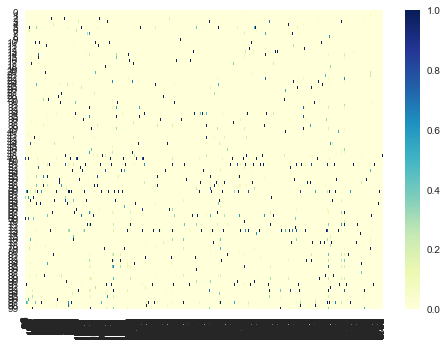

In [35]:
# see new svd feature distribution
sns.heatmap(normalization(merchant_dis), fmt="d", cmap='YlGnBu')
plt.show()

In [30]:
user_df = pd.DataFrame(user_dis)
user_df[:10]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.162324,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
1,0.0,0.0,0.000157,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
2,0.0,0.0,0.000022,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
3,0.0,0.0,0.000053,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
4,0.0,0.0,0.000067,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
5,0.0,0.0,0.000134,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
6,0.0,0.0,0.000291,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
7,0.0,0.0,0.000145,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,1.283137e-08
8,0.0,0.0,0.000014,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00
9,0.0,0.0,0.040548,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,...,5.184129e-10,1.653402e-07,0.0,0.0,0.0,3.522857e-08,0.000012,4.730786e-10,0.0,0.000000e+00


In [31]:
merchant_df = pd.DataFrame(merchant_dis.T)
merchant_df[:10]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,1.693343e-13,0.000000e+00,3.710718e-09,0.000000e+00,0.000000e+00,2.511145e-09,1.259905e-09,0.000000e+00,1.704919e-10,8.002497e-11
1,0.000000,0.0,0.0,0.000000,6.224576e-08,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,8.831188e-11,4.471932e-07,0.000000e+00,3.899297e-08,0.000000e+00,0.000000e+00,8.283822e-10,1.007304e-07
2,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,5.893479e-07,0.000000e+00,...,1.385953e-11,1.868916e-07,1.058073e-08,0.000000e+00,0.000000e+00,0.000000e+00,2.081137e-08,2.338482e-05,2.326228e-07,0.000000e+00
4,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,6.758559e-06,0.000000e+00,0.000000e+00,0.000000e+00,2.288439e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,0.000353,0.0,0.0,0.000587,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,3.521467e-01,0.000000e+00,1.531268e-04,1.532757e-06,1.719411e-04,0.000000e+00,1.228308e-04,8.750464e-06,2.386695e-04
6,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,2.053574e-07,5.749565e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,0.000000,0.0,0.0,0.000000,1.040644e-07,5.149386e-10,0.0,0.0,5.270332e-03,6.260858e-11,...,3.200397e-08,6.794396e-06,6.654236e-07,3.626102e-06,0.000000e+00,4.360099e-08,0.000000e+00,1.278203e-03,1.487705e-05,1.525640e-06
8,0.000000,0.0,0.0,0.007982,1.017227e-02,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,1.206659e-04,9.958004e-07,9.693579e-03,4.199431e-07,5.417309e-04,0.000000e+00,3.446431e-08,1.042221e-05,5.295908e-03
9,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.643329e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [19]:
np.save("user_dis.npy", user_dis)
np.save("merchant_dis.npy", merchant_dis)

In [29]:
print(feature.columns)

Index(['new_id', 'mer_id', 'loc_id', 'openning_date', 'last_purchase_date',
       'mer_loc_records', 'popularity', 'average_purchase_interval',
       'merchant_budget', 'merchant_rank', 'purchase_user_number',
       'buying_days'],
      dtype='object')


In [38]:
X = np.array(feature.loc[:, ['openning_date', 'last_purchase_date',
       'mer_loc_records', 'popularity', 'average_purchase_interval',
       'merchant_budget', 'merchant_rank', 'purchase_user_number',
       'buying_days']])
print(X.shape)
svd_X = np.concatenate((X, merchant_dis.T), axis=1)
print(svd_X.shape)

(6802, 9)
(6802, 109)


In [39]:
# Normalization for 9 dimensional data
min_max_scaler = preprocessing.MinMaxScaler()  
X_minMax = min_max_scaler.fit_transform(X)
print(X[:1, :])
print(X_minMax[:1, :])

[[0.00000000e+00 1.52000000e+02 1.95000000e+02 3.64077670e-02
  7.79487179e-01 5.24000000e+02 8.00000000e+00 9.40000000e+01
  8.00000000e+01]]
[[0.         1.         0.00354908 0.03639437 0.01097869 0.02460824
  0.03571429 0.01529857 0.51973684]]


In [40]:
# Normalization for 100+ dimensional data
min_max_scaler = preprocessing.MinMaxScaler()  
svd_X_minMax = min_max_scaler.fit_transform(svd_X)
print(svd_X[:1, :])
print(svd_X_minMax[:1, :])

[[0.00000000e+00 1.52000000e+02 1.95000000e+02 3.64077670e-02
  7.79487179e-01 5.24000000e+02 8.00000000e+00 9.40000000e+01
  8.00000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72987047e-09
  2.93896598e-12 7.71359966e-12 0.00000000e+00 0.00000000e+00
  9.73504602e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.00195974e-11 0.00000000e+00 0.00000000e+00
  6.66769699e-12 1.67756194e-12 8.02204823e-12 0.00000000e+00
  3.14049196e-08 0.00000000e+00 0.00000000e+00 3.63955635e-10
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.36116619e-07 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.02757616e-14 0.00000000e+00
  0.00000000e+00 4.98254068e-10 0.00000000e+00 0.00000000e+00
  3.66100204e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0000

In [49]:
def heat_map_for_original(X):
    sns.heatmap(X, fmt="d", cmap='YlGnBu')
    plt.show()
def normalization(X):
    min_max_scaler = preprocessing.MinMaxScaler()  
    X_minMax = min_max_scaler.fit_transform(X)
    print(X[:1, :])
    print(X_minMax[:1, :])
    return X_minMax
def show_clusters(data, clustering):
    index = []
    values = []
    cluster_maps = defaultdict(int)
    for i in range(len(data)):
        cluster_maps[clustering.labels_[i]] += 1
    for i in cluster_maps:
        index.append(i)
        values.append(cluster_maps[i])
    print(values)
    axes = plt.bar(index, values)
    plt.show()

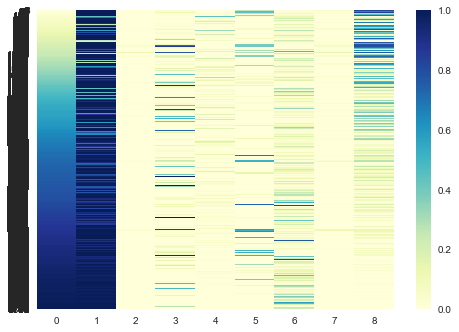

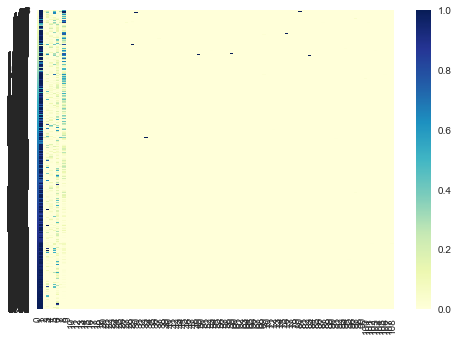

In [41]:
heat_map_for_original(X_minMax)
heat_map_for_original(svd_X_minMax)

In [54]:
def select_k_and_display(k_list, data):
    Calinski_Harabasz_k = 0
    Calinski_Harabasz_score = -1
    Calinski_Harabasz_cls = None
    ch_score_series = []
    
    Silhouette_k = 0
    Silhouette_score = -1
    Silhouette_cls = None
    sc_score_series = []
    for i in k_list:
        clustering = SpectralClustering(n_clusters=i,
                                        n_init=10, 
                                        gamma=1.0,
                                        affinity='rbf',
                                        assign_labels ='kmeans',
                                        n_jobs=5)
        cls = clustering.fit(data)
        y_pred = clustering.fit_predict(data)
        ch_score = metrics.calinski_harabaz_score(data, y_pred)
        s_score = metrics.silhouette_score(data, cls.labels_, metric='euclidean')
        
        ch_score_series.append(ch_score)
        sc_score_series.append(s_score)
        
        print("Calinski-Harabasz Score with n_clusters=", i,"score:", ch_score)
        print("Silhouette Score with n_clusters=", i,"score:", s_score)
        
        if ch_score > Calinski_Harabasz_score:
            Calinski_Harabasz_score = ch_score
            Calinski_Harabasz_k = i
            Calinski_Harabasz_cls = cls
            
        if abs(s_score - 1) < abs(Silhouette_score - 1):
            Silhouette_score = s_score
            Silhouette_k = i
            Silhouette_cls = cls
            
    print("The best Silhouette Score is "+str(Silhouette_score)+" and the best k is "+str(Silhouette_k))
    print("The best Calinski-Harabasz Score is "+str(Calinski_Harabasz_score)+" and the best k is "+str(Calinski_Harabasz_k))
    
    if Silhouette_k == Calinski_Harabasz_k:
        fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
#         heat_map_for_original(fit_data)
        show_clusters(data, Calinski_Harabasz_cls)
        
    else:
        ch_fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
#         heat_map_for_original(ch_fit_data)
        show_clusters(ch_fit_data, Calinski_Harabasz_cls)
        
        sc_fit_data = data[np.argsort(Silhouette_cls.labels_)]
#         heat_map_for_original(sc_fit_data)
        show_clusters(sc_fit_data, Silhouette_cls)
        
    plt.plot(k_list, ch_score_series)
    plt.title('Calinski_Harabasz_score trend with k increasing')
    plt.xlabel('k component number')
    plt.ylabel('Calinski_Harabasz_score')
#     plt.legend()
    plt.show()
    
    plt.plot(k_list, sc_score_series)
    plt.title('Silhouette_score trend with k increasing')
    plt.xlabel('k component number')
    plt.ylabel('Silhouette_score')
#     plt.legend()
    plt.show()

Calinski-Harabasz Score with n_clusters= 5 score: 2314.5983862476382
Silhouette Score with n_clusters= 5 score: 0.29136629241177786
Calinski-Harabasz Score with n_clusters= 10 score: 2222.266166168008
Silhouette Score with n_clusters= 10 score: 0.30000726057216975
Calinski-Harabasz Score with n_clusters= 15 score: 1791.4806752388738
Silhouette Score with n_clusters= 15 score: 0.29026434924185285
Calinski-Harabasz Score with n_clusters= 20 score: 1588.487958346992
Silhouette Score with n_clusters= 20 score: 0.24978651394280135
Calinski-Harabasz Score with n_clusters= 25 score: 1522.6456672560812
Silhouette Score with n_clusters= 25 score: 0.24372288490705948
Calinski-Harabasz Score with n_clusters= 30 score: 1280.4102579064422
Silhouette Score with n_clusters= 30 score: 0.224858780554253
Calinski-Harabasz Score with n_clusters= 40 score: 1070.01138308582
Silhouette Score with n_clusters= 40 score: 0.2110159443533811
Calinski-Harabasz Score with n_clusters= 50 score: 858.9260276056087
Si

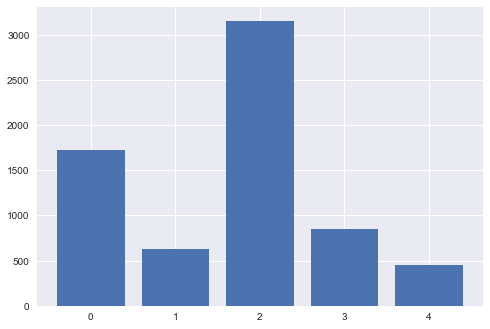

[412, 102, 849, 220, 272, 1322, 491, 260, 982, 1892]


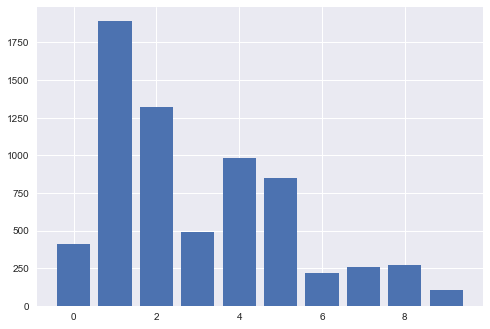

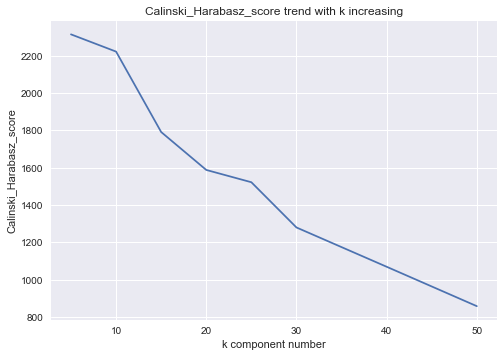

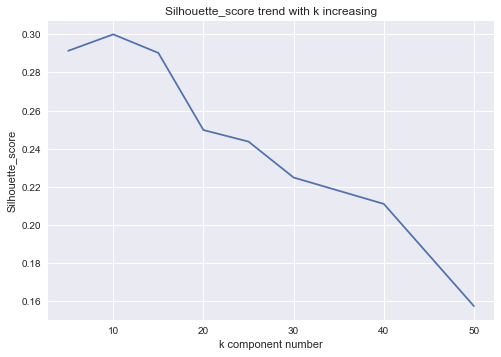

Calinski-Harabasz Score with n_clusters= 5 score: 2106.844807911435
Silhouette Score with n_clusters= 5 score: 0.2783008522950938
Calinski-Harabasz Score with n_clusters= 10 score: 1623.5808964055125
Silhouette Score with n_clusters= 10 score: 0.2847912237298626
Calinski-Harabasz Score with n_clusters= 15 score: 1029.8172875901314
Silhouette Score with n_clusters= 15 score: 0.23077452857679687
Calinski-Harabasz Score with n_clusters= 20 score: 1039.0717186894333
Silhouette Score with n_clusters= 20 score: 0.2194018967949539
Calinski-Harabasz Score with n_clusters= 25 score: 819.9556699206885
Silhouette Score with n_clusters= 25 score: 0.2000249645195262
Calinski-Harabasz Score with n_clusters= 30 score: 753.3385194260853
Silhouette Score with n_clusters= 30 score: 0.20445662817713897
Calinski-Harabasz Score with n_clusters= 40 score: 570.9292057324286
Silhouette Score with n_clusters= 40 score: 0.17250189186080103
Calinski-Harabasz Score with n_clusters= 50 score: 482.9129562938376
Sil

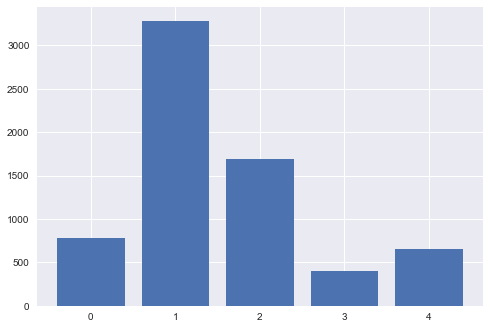

[423, 103, 1874, 841, 217, 270, 1379, 492, 945, 258]


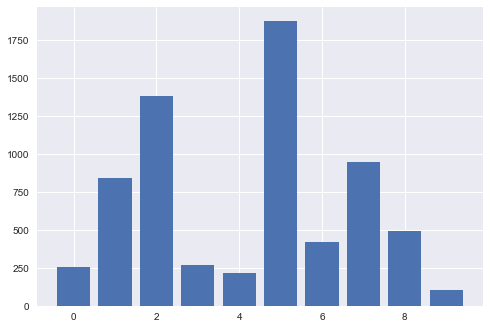

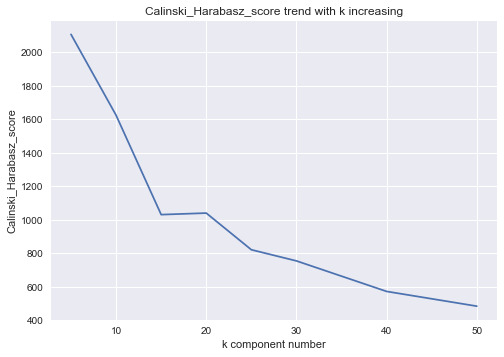

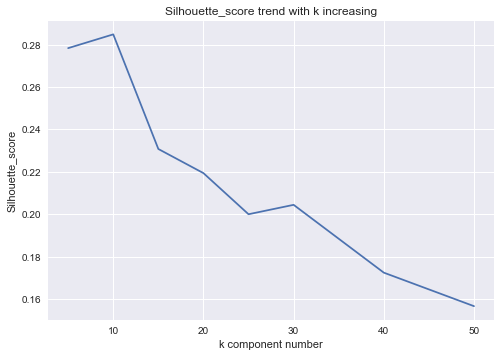

In [55]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]

select_k_and_display(k_list, X_minMax)

select_k_and_display(k_list, svd_X_minMax)

/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/l

Calinski-Harabasz Score with n_clusters= 2 score: 1.1920482193088648
Silhouette Score with n_clusters= 2 score: -0.019862467768717015
Calinski-Harabasz Score with n_clusters= 4 score: 1.388874427907253
Silhouette Score with n_clusters= 4 score: -0.038723424310578486
Calinski-Harabasz Score with n_clusters= 8 score: 1.4060908468949864
Silhouette Score with n_clusters= 8 score: -0.04051605561787559


/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/l

Calinski-Harabasz Score with n_clusters= 16 score: 1.3276847838892782
Silhouette Score with n_clusters= 16 score: -0.04287336532777927
Calinski-Harabasz Score with n_clusters= 32 score: 1.255610926405638
Silhouette Score with n_clusters= 32 score: -0.04056546541876977


/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


Calinski-Harabasz Score with n_clusters= 64 score: 1.1862359576832813
Silhouette Score with n_clusters= 64 score: -0.012700091191450118
The best Silhouette Score is -0.012700091191450118 and the best k is 64
The best Calinski-Harabasz Score is 1.4060908468949864 and the best k is 8


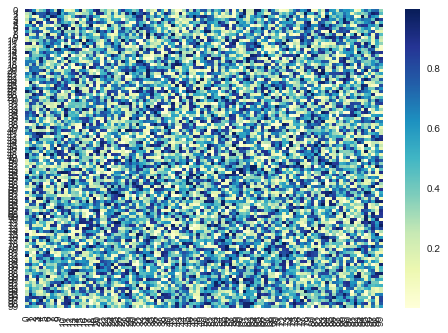

[72, 9, 4, 2, 3, 3, 5, 2]


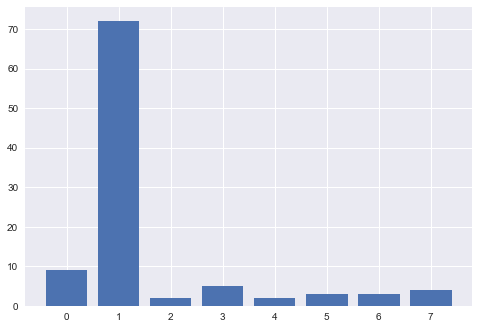

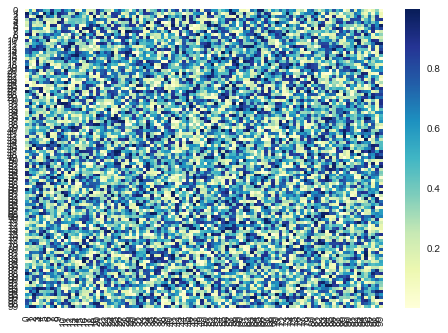

[2, 1, 3, 8, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 9, 1, 1, 2, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


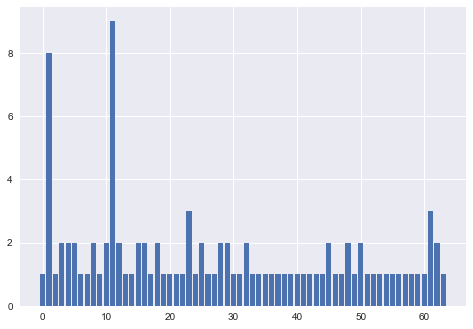

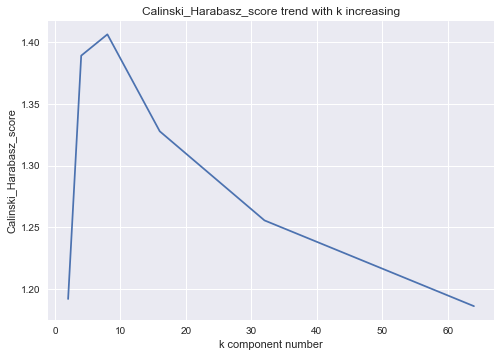

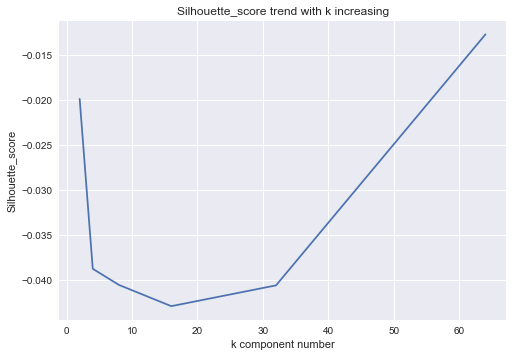

In [53]:
# test
rr = np.random.rand(100, 100)
k_list = [2,4,8,16,32,64]

select_k_and_display(k_list, rr)



Calinski-Harabasz Score with n_clusters= 2 score: 3941.940059907304
Silhouette Score with n_clusters= 2 score: 0.3962189147738085
Calinski-Harabasz Score with n_clusters= 4 score: 2814.683628941118
Silhouette Score with n_clusters= 4 score: 0.400610584507829
Calinski-Harabasz Score with n_clusters= 8 score: 2146.707458368622
Silhouette Score with n_clusters= 8 score: 0.3057805094194816
Calinski-Harabasz Score with n_clusters= 16 score: 1768.1923711402474
Silhouette Score with n_clusters= 16 score: 0.25619327749276505
Calinski-Harabasz Score with n_clusters= 32 score: 1268.97972111518
Silhouette Score with n_clusters= 32 score: 0.22189089785099847
Calinski-Harabasz Score with n_clusters= 64 score: 770.6683598229783
Silhouette Score with n_clusters= 64 score: 0.10604581181468054
The best Silhouette Score is 0.400610584507829 and the best k is 4
The best Calinski-Harabasz Score is 3941.940059907304 and the best k is 2


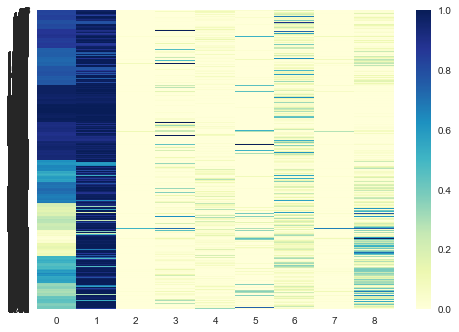

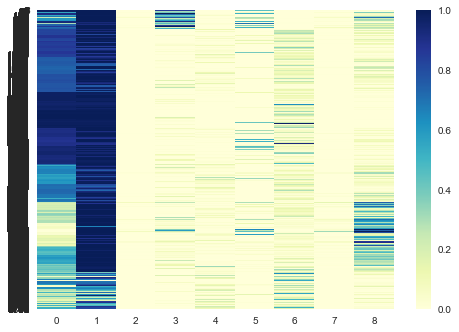

Calinski-Harabasz Score with n_clusters= 2 score: 3533.660729494376
Silhouette Score with n_clusters= 2 score: 0.3884621866629075
Calinski-Harabasz Score with n_clusters= 4 score: 2395.2597294516822
Silhouette Score with n_clusters= 4 score: 0.3881512861012259
Calinski-Harabasz Score with n_clusters= 8 score: 1798.902420298053
Silhouette Score with n_clusters= 8 score: 0.2899910047258182
Calinski-Harabasz Score with n_clusters= 16 score: 1028.0597311556228
Silhouette Score with n_clusters= 16 score: 0.22514337077127644
Calinski-Harabasz Score with n_clusters= 32 score: 579.8408098783326
Silhouette Score with n_clusters= 32 score: 0.17851142391769895
Calinski-Harabasz Score with n_clusters= 64 score: 373.2817879189359
Silhouette Score with n_clusters= 64 score: 0.15458118791201303
The best Silhouette Score is 0.3884621866629075 and the best k is 2
The best Calinski-Harabasz Score is 3533.660729494376 and the best k is 2


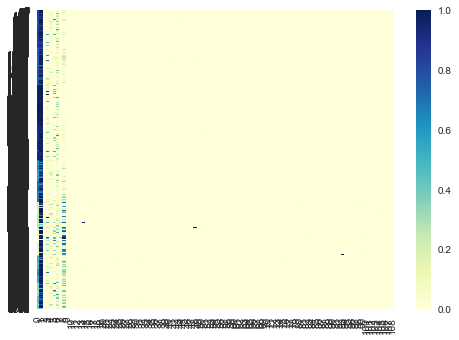

In [44]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]

select_k_and_display(k_list, X_minMax)

select_k_and_display(k_list, svd_X_minMax)

In [57]:
print(svd_X_minMax.shape, X_minMax.shape)
np.save("merchant_explcit_features.npy", X_minMax)
np.save("merchant_explcit_svd_features.npy", svd_X_minMax)

(6802, 109) (6802, 9)


In [58]:
# poly kernel
poly_clustering = SpectralClustering(n_clusters=10, 
                                    n_init=10, 
                                    gamma=1.0,
                                    affinity='poly',
                                    assign_labels ='kmeans',
                                    degree=3,
                                    coef0=1,
                                    n_jobs=5)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_
# knn kernel
knn_clustering = SpectralClustering(n_clusters=10, 
                                    n_init=10, 
                                    affinity='nearest_neighbors',
                                    n_neighbors=10,
                                    assign_labels ='kmeans',
                                    n_jobs=5)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_
# cosine kernel
cos_clustering = SpectralClustering(n_clusters=10, 
                                n_init=10, 
                                affinity='cosine',
                                assign_labels ='kmeans',
                                n_jobs=5)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_


In [63]:
model_list = [poly_clustering, knn_clustering, cos_clustering]

In [67]:
def select_k_and_kernel(k_list, data, model_list):
    
    for j in model_list:
        Calinski_Harabasz_k = 0
        Calinski_Harabasz_score = -1
        Calinski_Harabasz_cls = None
        ch_score_series = []

        Silhouette_k = 0
        Silhouette_score = -1
        Silhouette_cls = None
        sc_score_series = []
        for i in k_list:
            j.set_params(n_clusters=i)
            print("Begin tuning the model", j.get_params())
            cls = j.fit(data)
            y_pred = j.fit_predict(data)
            ch_score = metrics.calinski_harabaz_score(data, y_pred)
            s_score = metrics.silhouette_score(data, cls.labels_, metric='euclidean')

            ch_score_series.append(ch_score)
            sc_score_series.append(s_score)

            print("Calinski-Harabasz Score with n_clusters=", i,"score:", ch_score)
            print("Silhouette Score with n_clusters=", i,"score:", s_score)

            if ch_score > Calinski_Harabasz_score:
                Calinski_Harabasz_score = ch_score
                Calinski_Harabasz_k = i
                Calinski_Harabasz_cls = deepcopy(cls)

            if abs(s_score - 1) < abs(Silhouette_score - 1):
                Silhouette_score = s_score
                Silhouette_k = i
                Silhouette_cls = deepcopy(cls)

        print("The best Silhouette Score is "+str(Silhouette_score)+" and the best k is "+str(Silhouette_k))
        print("The best Calinski-Harabasz Score is "+str(Calinski_Harabasz_score)+" and the best k is "+str(Calinski_Harabasz_k))

        if Silhouette_k == Calinski_Harabasz_k:
            fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
    #         heat_map_for_original(fit_data)
            show_clusters(data, Calinski_Harabasz_cls)

        else:
            ch_fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
    #         heat_map_for_original(ch_fit_data)
            show_clusters(ch_fit_data, Calinski_Harabasz_cls)

            sc_fit_data = data[np.argsort(Silhouette_cls.labels_)]
    #         heat_map_for_original(sc_fit_data)
            show_clusters(sc_fit_data, Silhouette_cls)

        plt.plot(k_list, ch_score_series)
        plt.title('Calinski_Harabasz_score trend with k increasing')
        plt.xlabel('k component number')
        plt.ylabel('Calinski_Harabasz_score')
    #     plt.legend()
        plt.show()

        plt.plot(k_list, sc_score_series)
        plt.title('Silhouette_score trend with k increasing')
        plt.xlabel('k component number')
        plt.ylabel('Silhouette_score')
    #     plt.legend()
        plt.show()

Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 2242.7161352966887
Silhouette Score with n_clusters= 5 score: 0.29112874474562495
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 1715.1458057818058
Silhouette Score with n_clusters= 10 score: 0.26718868518933836
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs': 5,

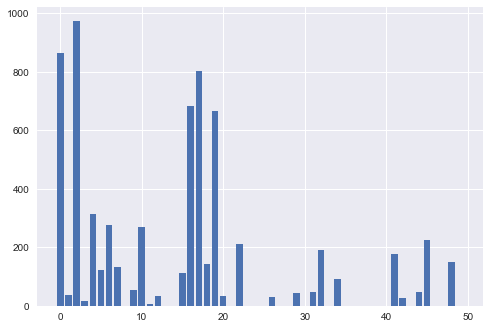

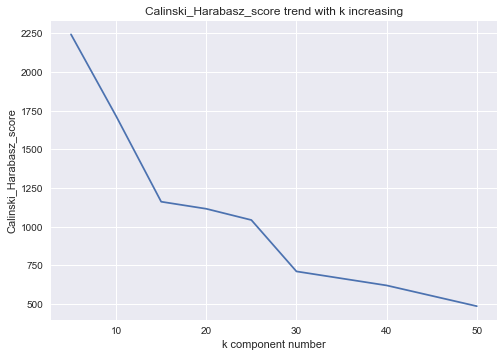

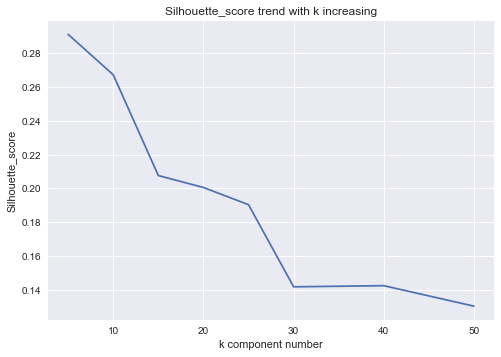

Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1655.569274934253
Silhouette Score with n_clusters= 5 score: 0.1383273910958354
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 1919.7709410636828
Silhouette Score with n_clusters= 10 score: 0.21909066014739909
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clus

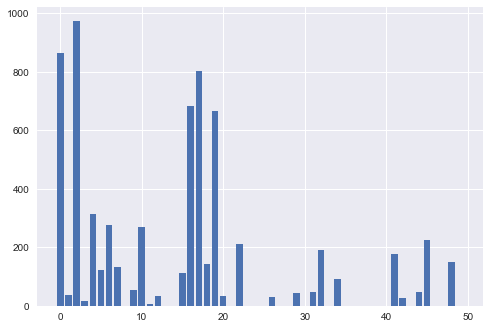

ValueError: x and y must have same first dimension, but have shapes (8,) and (16,)

In [60]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
# select_k_and_kernel(k_list, X_minMax, model_list)
select_k_and_kernel(k_list, svd_X_minMax, model_list)

Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1655.8260512942168
Silhouette Score with n_clusters= 5 score: 0.1385188806344405
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 1919.8708667186268
Silhouette Score with n_clusters= 10 score: 0.21908907697642638
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clu

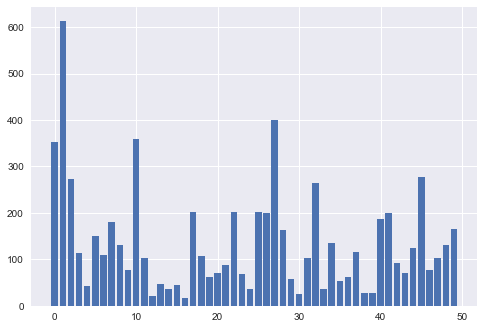

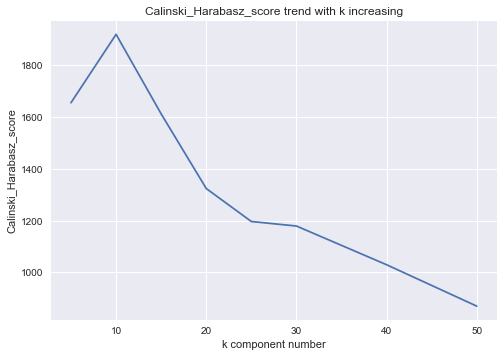

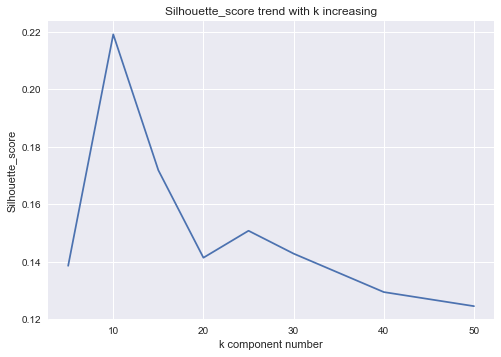

Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 2028.9707711381789
Silhouette Score with n_clusters= 5 score: 0.3419929301287014
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 955.9693789349847
Silhouette Score with n_clusters= 10 score: -0.01293458097481596
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs

KeyboardInterrupt: 

In [62]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
select_k_and_kernel(k_list, X_minMax, model_list)

Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1921.9543237297755
Silhouette Score with n_clusters= 5 score: 0.28540558764838947
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 1391.12933724041
Silhouette Score with n_clusters= 10 score: 0.2601426347681066
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs': 5, 'n

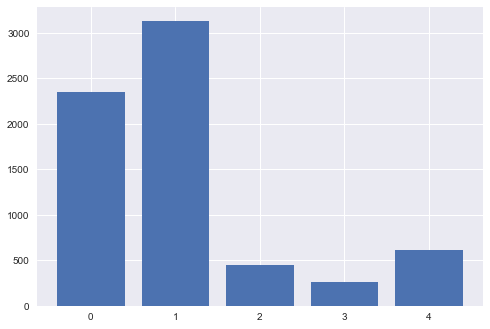

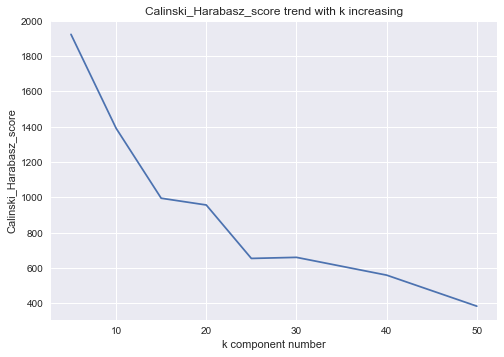

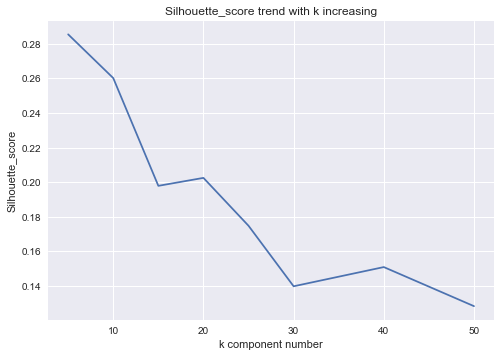

Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1451.4365131255975
Silhouette Score with n_clusters= 5 score: 0.12645771311432044
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 1515.7603111513226
Silhouette Score with n_clusters= 10 score: 0.20435251242536379
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_cl

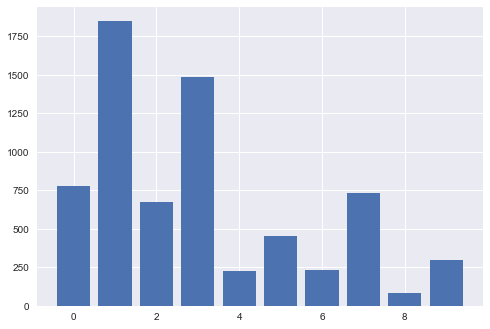

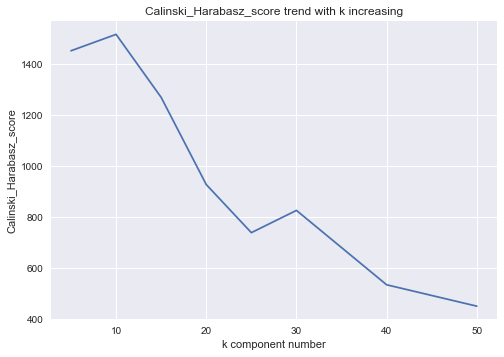

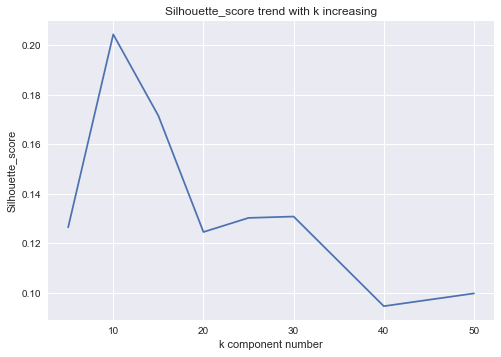

Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1748.36367965269
Silhouette Score with n_clusters= 5 score: 0.33066040155711396
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 842.5446799680481
Silhouette Score with n_clusters= 10 score: 0.3038093523023882
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs': 

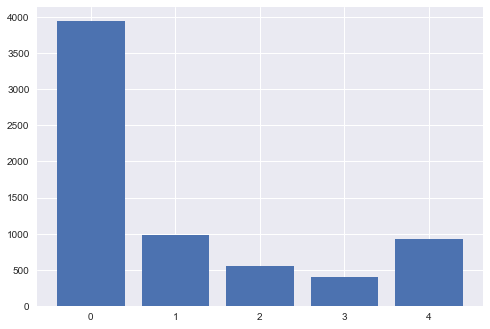

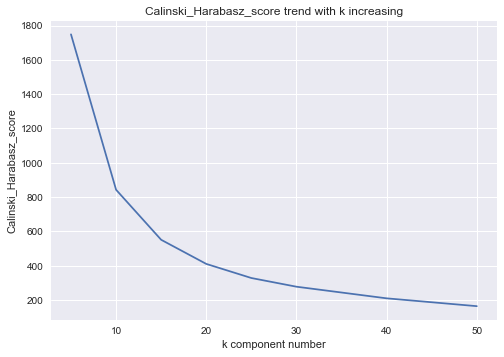

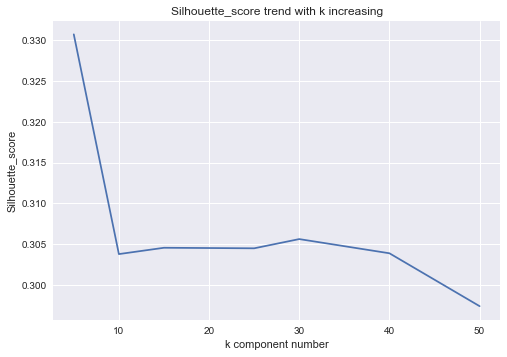

In [68]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
# select_k_and_kernel(k_list, X_minMax, model_list)
select_k_and_kernel(k_list, svd_X_minMax, model_list)


In [70]:
print(feature.columns)

Index(['new_id', 'mer_id', 'loc_id', 'openning_date', 'last_purchase_date',
       'mer_loc_records', 'popularity', 'average_purchase_interval',
       'merchant_budget', 'merchant_rank', 'purchase_user_number',
       'buying_days'],
      dtype='object')


In [71]:
col_names = ['openning_date', 'last_purchase_date',
       'mer_loc_records', 'popularity', 'average_purchase_interval',
       'merchant_budget', 'merchant_rank', 'purchase_user_number',
       'buying_days']
for i in range(100):
    col_names.append('svd_feature_'+str(i+1))
print(col_names)

['openning_date', 'last_purchase_date', 'mer_loc_records', 'popularity', 'average_purchase_interval', 'merchant_budget', 'merchant_rank', 'purchase_user_number', 'buying_days', 'svd_feature_1', 'svd_feature_2', 'svd_feature_3', 'svd_feature_4', 'svd_feature_5', 'svd_feature_6', 'svd_feature_7', 'svd_feature_8', 'svd_feature_9', 'svd_feature_10', 'svd_feature_11', 'svd_feature_12', 'svd_feature_13', 'svd_feature_14', 'svd_feature_15', 'svd_feature_16', 'svd_feature_17', 'svd_feature_18', 'svd_feature_19', 'svd_feature_20', 'svd_feature_21', 'svd_feature_22', 'svd_feature_23', 'svd_feature_24', 'svd_feature_25', 'svd_feature_26', 'svd_feature_27', 'svd_feature_28', 'svd_feature_29', 'svd_feature_30', 'svd_feature_31', 'svd_feature_32', 'svd_feature_33', 'svd_feature_34', 'svd_feature_35', 'svd_feature_36', 'svd_feature_37', 'svd_feature_38', 'svd_feature_39', 'svd_feature_40', 'svd_feature_41', 'svd_feature_42', 'svd_feature_43', 'svd_feature_44', 'svd_feature_45', 'svd_feature_46', 'svd

In [ ]:
new_df = pd.DataFrame(svd_X_minMax, columns = col_names)

In [90]:
new_df[:10]

,openning_date,last_purchase_date,mer_loc_records,popularity,average_purchase_interval,merchant_budget,merchant_rank,purchase_user_number,buying_days,svd_feature_1,...,svd_feature_94,svd_feature_95,svd_feature_96,svd_feature_97,svd_feature_98,svd_feature_99,svd_feature_100,new_id,merchant_id,location_id
0,0.000000,1.0,0.003549,0.036394,0.010979,0.024608,0.035714,0.015299,0.519737,0.000000,...,0.000000e+00,0.000000e+00,1.858177e-10,9.998418e-11,0.000000e+00,1.309426e-11,6.508938e-12,1,210,410
1,0.000000,1.0,0.002872,0.040782,0.013550,0.100522,0.020408,0.010035,0.565789,0.000000,...,2.375742e-08,0.000000e+00,2.885370e-09,0.000000e+00,0.000000e+00,6.362213e-11,8.193045e-09,2,625,130
2,0.000000,1.0,0.110534,0.244744,0.000354,0.442310,0.005102,0.415858,1.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,5231,337
3,0.000000,1.0,0.003293,0.344753,0.011828,0.098955,0.000000,0.016615,0.651316,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,1.651559e-09,1.797340e-06,1.786609e-08,0.000000e+00,4,216,407
4,0.006579,1.0,0.009495,0.033438,0.004090,0.264771,0.010204,0.053134,0.815789,0.000000,...,0.000000e+00,0.000000e+00,1.693381e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5,4565,461
5,0.006579,1.0,0.060920,0.753787,0.000638,0.442310,0.000000,0.364205,0.993421,0.000011,...,8.134959e-06,1.134027e-07,1.272316e-05,0.000000e+00,9.440684e-06,6.720606e-07,1.941251e-05,6,5231,246
6,0.006579,1.0,0.170319,0.845300,0.000228,0.442310,0.000000,1.000000,0.993421,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7,5231,371
7,0.006579,1.0,0.046010,0.280012,0.000845,0.442310,0.000000,0.193617,0.993421,0.000000,...,1.926390e-07,0.000000e+00,3.226351e-09,0.000000e+00,9.824169e-05,1.142600e-06,1.240900e-07,8,5231,69
8,0.006579,1.0,0.050364,0.112121,0.000772,0.442310,0.010204,0.265669,0.993421,0.000000,...,5.149775e-04,3.106996e-08,4.008657e-05,0.000000e+00,2.648901e-09,8.004554e-07,4.307498e-04,9,5231,348
9,0.006579,1.0,0.031356,0.133941,0.001240,0.647359,0.015306,0.081428,0.973684,0.000000,...,0.000000e+00,5.655002e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10,2641,52


In [86]:
new_df['new_id'] = feature['new_id']

In [87]:
new_df['merchant_id'] = feature['mer_id']

In [88]:
new_df['location_id'] = feature['loc_id']

In [89]:
print(new_df.shape)

(6802, 112)


In [91]:
clustering = SpectralClustering(n_clusters=10,
                                n_init=10, 
                                gamma=1.0,
                                affinity='rbf',
                                assign_labels ='kmeans',
                                n_jobs=5)
cls = clustering.fit(svd_X_minMax)
new_df['cluster_label'] = cls.labels_

In [92]:
print(metrics.silhouette_score(svd_X_minMax, cls.labels_, metric='euclidean'))

0.28492162311230357


In [94]:
new_df.to_csv("merchant_clusters.csv", index=False)